In [328]:
# Importing The Necessary Libraries
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from IPython.display import Image
import logging
import time
import os
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Scrapping

In [ ]:
# Chrome driver setup
options = Options()
# options.add_argument('--headless')  
options.add_argument('--disable-gpu')
driver_path = 'chromedriver-mac-x64/chromedriver'  

# Initialize the WebDriver
service = Service(driver_path)
driver = webdriver.Chrome(service=service, options=options)

try:
    # Open the Sephora URL
    url = "https://www.sephora.fr/shop/soin-visage/type-de-soin/gommage-et-peeling-visage-c7684/" 
    driver.get(url)
    
    # Wait for the page to load
    time.sleep(2)

    # Find the button using its ID and click it
    button = driver.find_element(By.ID, "footer_tc_privacy_button_2")
    print(button)
    button.click()

    see_more_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.CLASS_NAME, "see-more-button"))
    )
    print(see_more_button)
    see_more_button.click()

    # Wait to see the result of the click, for example, an alert
    time.sleep(2)

    scroll_pause_time = 3 # You can set your own pause time. My laptop is a bit slow so I use 1 sec
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
    i = 1
    while True:
        # scroll one screen height each time
        driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  
        i += 1
        time.sleep(scroll_pause_time)
        # update scroll height each time after scrolled, as the scroll height can change after we scrolled the page
        scroll_height = driver.execute_script("return document.body.scrollHeight;")  
        # Break the loop when the height we need to scroll to is larger than the total scroll height
        if (screen_height) * i > scroll_height:
            break 
        # Fetch product URLs after the loading is complete
    
    products = driver.find_elements(By.CLASS_NAME, "product-tile-link")  # Use the class name for product links

    for product in products:
        url = product.get_attribute('href')
        if url:
            urls.add(url)

    # Write URLs to an Excel file
    df = pd.DataFrame(list(urls), columns=['Product URL'])
    df.to_excel('sephora_product_urls.xlsx', index=False)

    print("All URLs have been saved to sephora_product_urls.xlsx")

finally:
    # Close the browser
    # driver.quit()
    print("done")


In [75]:
product_urls = pd.read_excel('sephora_product_urls.xlsx')

In [ ]:
# Configure the logging
logging.basicConfig(
    filename='processed_urls.log',  # Name of the log file
    level=logging.INFO,  # Logging level
    format='%(asctime)s - %(message)s',  # Log message format
    datefmt='%Y-%m-%d %H:%M:%S'  # Date and time format
)
# Chrome driver setup
options = Options()
options.add_argument('--headless')  # Uncomment this to run in headless mode
# options.add_argument('--disable-gpu')
driver_path = 'chromedriver-mac-x64/chromedriver'  # Update this with the path to your chromedriver

# Initialize the WebDriver
service = Service(driver_path)
driver = webdriver.Chrome(service=service, options=options)

try:
    driver.get("https://www.sephora.fr")
    button = driver.find_element(By.ID, "footer_tc_privacy_button_2")
    button.click()
except Exception as e:
        print("No button to click:", e)

# URL of the product page
# product_url = "https://www.sephora.fr/p/le-lift-pro---creme-volume--corrige--redessine--repulpe-619438.html"

def process_url(url):
    # Simulate URL processing
    logging.info(f'Processed URL: {url}')
    print(f'Processed URL: {url}')

def get_all_reviews(product_url):
    driver.get(product_url)
    
    # Wait for page to load
    time.sleep(3)
    

    # Locate the elements and extract the information
    brand_name = driver.find_element(By.CLASS_NAME, 'brand-name').text  # Ensure this class is correct

    product_name = driver.find_element(By.CLASS_NAME, 'product-title-heading').text  # Ensure this class is correct

    price = driver.find_element(By.XPATH, '//*[@id="product-content"]/div[2]/div/div[1]/span').text  # Ensure this class is correct

    variation_qty = driver.find_element(By.XPATH, '//*[@id="product-content"]/div[3]/ul/li/a/div/span').text  

    review_count_str = driver.find_element(By.XPATH, '//*[@id="ratings-summary"]/div[2]/span[2]').text  # Ensure this class is correct
    review_count = review_count_str.split()[0]
    review_count = int(review_count)



    # Initialize N outside the function
    N = 0

    def load_more_reviews():
        try:
            # Wait for the "See More Reviews" button to be clickable and then click
            see_more_reviews = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.CLASS_NAME, "see-more-reviews"))  # Update this selector as needed
            )
            see_more_reviews.click()
            time.sleep(2)  # Wait briefly for more reviews to load
            # return True
        except Exception as e:
            print("Error or no more reviews to load:", e)
            # return False

    if review_count>0:
        # Load all reviews
        wait = WebDriverWait(driver, 10)  # wait for up to 10 seconds

        # Wait for the element to be present
        review_overall_score_element = wait.until(
            EC.presence_of_element_located((By.XPATH, '//*[@id="reviews-content"]/div[1]/div[1]/div[1]')))

        # Get the text from the element
        review_overall_score = review_overall_score_element.text
        # review_overall_score = driver.find_element(By.XPATH, '//*[@id="reviews-content"]/div[1]/div[1]/div[1]').text  # Ensure this class is correct

        while N<5:
            load_more_reviews()
            N=N+1
            print("Loading more reviews...")

        # Collecting the reviews
        reviews = []
        review_elements = driver.find_element(By.CLASS_NAME, "reviews-wrapper")  # Adjust class name as necessary
        current_reviews = review_elements.find_elements(By.CLASS_NAME, "block-review")
        
        for review_element in current_reviews:
                # Extract reviewer name, age, and sex
                p_tags = review_element.find_element(By.CLASS_NAME, "info-review").find_elements(By.TAG_NAME, "p")
                reviewer_name = p_tags[0].text if p_tags else "N/A"
                age = sex = None

                for p in p_tags[1:]:
                    text = p.text.strip()
                    if text.startswith("Age:"):
                        age = text.replace("Age:", "").strip()
                    elif text.startswith("Sexe:"):
                        sex = text.replace("Sexe:", "").strip()
                
                # Locate the review element
                rating_content = review_element.find_element(By.CLASS_NAME, "rating-content")

                # Extract the date
                date_p_tag = rating_content.find_element(By.TAG_NAME, "p")
                review_date = date_p_tag.text if date_p_tag else "N/A"

                # Extract the overall rating (e.g., "5/5")
                rating_text_div = rating_content.find_element(By.CSS_SELECTOR, "div.bv_stars_component_container")
                rating_text = rating_text_div.text.strip() if rating_text_div else "N/A"

                review_comment = review_element.find_element(By.CLASS_NAME, "review-comment")

                # Find all <p> tags within the review element
                p_tags = review_comment.find_elements(By.TAG_NAME, "p")

                # Initialize variables for the components of interest
                review_title = review_description = review_recommendation = "N/A"

                # Extract information from each <p> tag
                for p in p_tags:
                    text = p.text.strip()
                    # Determine the category of each <p> based on its class or content
                    if "review-comment__title" == p.get_attribute("class"):
                        review_title = text
                    elif "review-comment__text" == p.get_attribute("class"):
                        review_description = text
                    elif "review-comment__recommendation" == p.get_attribute("class"):
                        review_recommendation = text.split(":")[-1].strip()  # Extract Yes/No

                # Append the review to the list
                reviews.append({
                    'product_name':product_name,
                    'brand':brand_name,
                    'price':price,
                    'variation_qty':variation_qty,
                    'total_review_count':review_count,
                    'overall_rating':review_overall_score,
                    'reviewer_name': reviewer_name,
                    'age': age,
                    'sex': sex,
                    'date': review_date,
                    'rating': rating_text,
                    'title': review_title,
                    'review_description': review_description,
                    'recommendation': review_recommendation,
                    'url':product_url
                })
        # driver.quit()
        return reviews
    else:
        reviews = {
            'product_name':product_name,
            'brand':brand_name,
            'price':price,
            'variation_qty':variation_qty,
            'total_review_count':review_count,
            'overall_rating':None,
            'reviewer_name': None,
            'age': None,
            'sex': None,
            'date': None,
            'rating': None,
            'title': None,
            'review_description': None,
            'recommendation': None,
            'url':product_url
        }
        # driver.quit()
        return [reviews]

def main():

    result_df = pd.DataFrame()
    product_urls = pd.read_excel('sephora_product_urls.xlsx')

    for i,url in enumerate(product_urls['Product URL']):
        if i<151:
            continue
        print(i)
        reviews = get_all_reviews(url)
        df = pd.DataFrame(reviews)
        # Append the new DataFrame to the empty DataFrame using `concat`
        result_df = pd.concat([result_df, df], ignore_index=True)

        df.to_excel(f'docs/sephora_product_details_{i}.xlsx', index=False)
    print("All URLs have been saved to sephora_product_urls.xlsx")

if __name__ == "__main__":
    main()

In [6]:
# Specify the folder containing the Excel files
folder_path = 'docs'

# List to hold dataframes
dataframes = []

# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.xlsx'):  # Check for Excel files
        file_path = os.path.join(folder_path, filename)
        # Read the Excel file and append the dataframe to the list
        df = pd.read_excel(file_path)
        dataframes.append(df)

# Concatenate all dataframes into a single dataframe
master_df = pd.concat(dataframes, ignore_index=True)

# Specify the output file path
output_file_path = r'sephore_product_data_file.xlsx'

# Write the master dataframe to an Excel file
master_df.to_excel(output_file_path, index=False)

print("All Excel files have been concatenated into the master file.")

All Excel files have been concatenated into the master file.


In [234]:
master_df = pd.read_excel('sephore_product_data_file.xlsx')

In [235]:
master_df.shape

(2381, 15)

In [236]:
master_df.head(10)

,product_name,brand,price,variation_qty,total_review_count,overall_rating,reviewer_name,age,sex,date,rating,title,review_description,recommendation,url
0,Disques Eclat du Visage - Soin aux Acides Glyc...,FIRST AID BEAUTY,"39,90€",60 disques,14,4.9/5\n14 avis,Danuniverse,25-34 ans,NaN,19/01/2024,5/5,Parfait,Ces disques sont un jeu-changer pour ma routin...,Oui,https://www.sephora.fr/p/disques-eclat-du-visa...
1,Disques Eclat du Visage - Soin aux Acides Glyc...,FIRST AID BEAUTY,"39,90€",60 disques,14,4.9/5\n14 avis,Willy,NaN,Homme,09/12/2023,4/5,J’aime beaucoup !,"Les disques démaquillant, nettoyant que j’ai a...",NaN,https://www.sephora.fr/p/disques-eclat-du-visa...
2,Disques Eclat du Visage - Soin aux Acides Glyc...,FIRST AID BEAUTY,"39,90€",60 disques,14,4.9/5\n14 avis,Willy,NaN,Homme,09/12/2023,5/5,Top,"J’ai disque démaquillant, nettoyant que j’ai r...",Oui,https://www.sephora.fr/p/disques-eclat-du-visa...
3,Disques Eclat du Visage - Soin aux Acides Glyc...,FIRST AID BEAUTY,"39,90€",60 disques,14,4.9/5\n14 avis,Sassouh34,25-34 ans,NaN,01/12/2023,5/5,Efficace et pratique,"Format très pratiques , ces disques prêts à l'...",Oui,https://www.sephora.fr/p/disques-eclat-du-visa...
4,Disques Eclat du Visage - Soin aux Acides Glyc...,FIRST AID BEAUTY,"39,90€",60 disques,14,4.9/5\n14 avis,Laeti,35-44 ans,NaN,23/11/2023,5/5,Mes chouchou,"Alors là c’est un de mes produits chouchou, j’...",Oui,https://www.sephora.fr/p/disques-eclat-du-visa...
5,Disques Eclat du Visage - Soin aux Acides Glyc...,FIRST AID BEAUTY,"39,90€",60 disques,14,4.9/5\n14 avis,Marg1507,18-24 ans,NaN,22/11/2023,4/5,J’adore ce produit,Ces disques exfoliant sont vraiment top. J’ai ...,Oui,https://www.sephora.fr/p/disques-eclat-du-visa...
6,Disques Eclat du Visage - Soin aux Acides Glyc...,FIRST AID BEAUTY,"39,90€",60 disques,14,4.9/5\n14 avis,Barbaraaa1,18-24 ans,NaN,22/11/2023,5/5,Top,Je n'ai pas connu ce produit avant franchement...,Oui,https://www.sephora.fr/p/disques-eclat-du-visa...
7,Disques Eclat du Visage - Soin aux Acides Glyc...,FIRST AID BEAUTY,"39,90€",60 disques,14,4.9/5\n14 avis,Franc92,25-34 ans,NaN,17/11/2023,5/5,Amazing,Les Disques Éclat du Visage sont un exfoliant ...,Oui,https://www.sephora.fr/p/disques-eclat-du-visa...
8,Disques Eclat du Visage - Soin aux Acides Glyc...,FIRST AID BEAUTY,"39,90€",60 disques,14,4.9/5\n14 avis,Bouthy,18-24 ans,NaN,17/11/2023,5/5,Magnifique produits,Magnifiques disques exfoliants! Ça permet de l...,Oui,https://www.sephora.fr/p/disques-eclat-du-visa...
9,Disques Eclat du Visage - Soin aux Acides Glyc...,FIRST AID BEAUTY,"39,90€",60 disques,14,4.9/5\n14 avis,Mimiedps,25-34 ans,Femme,13/11/2023,5/5,Je suis fan,"Les patchs sont dingue, ils sont doux frais ra...",Oui,https://www.sephora.fr/p/disques-eclat-du-visa...


In [237]:
# Check for missing values
missing_values = master_df.isnull().sum()

# Check the data types
data_types = master_df.dtypes

# Check for duplicates
duplicates = master_df.duplicated().sum()

# Display the results
missing_values, data_types, duplicates

(product_name            0
 brand                   0
 price                   0
 variation_qty         119
 total_review_count      0
 overall_rating         18
 reviewer_name          79
 age                   909
 sex                   918
 date                   56
 rating                 56
 title                  68
 review_description     58
 recommendation        868
 url                     0
 dtype: int64,
 product_name          object
 brand                 object
 price                 object
 variation_qty         object
 total_review_count     int64
 overall_rating        object
 reviewer_name         object
 age                   object
 sex                   object
 date                  object
 rating                object
 title                 object
 review_description    object
 recommendation        object
 url                   object
 dtype: object,
 19)

In [238]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   product_name        2381 non-null   object
 1   brand               2381 non-null   object
 2   price               2381 non-null   object
 3   variation_qty       2262 non-null   object
 4   total_review_count  2381 non-null   int64 
 5   overall_rating      2363 non-null   object
 6   reviewer_name       2302 non-null   object
 7   age                 1472 non-null   object
 8   sex                 1463 non-null   object
 9   date                2325 non-null   object
 10  rating              2325 non-null   object
 11  title               2313 non-null   object
 12  review_description  2323 non-null   object
 13  recommendation      1513 non-null   object
 14  url                 2381 non-null   object
dtypes: int64(1), object(14)
memory usage: 279.2+ KB


In [239]:
# Calculating basic descriptive statistics for the dataset
descriptive_stats = master_df.describe(include=[int, float])

# For object types, we will get some general information 
categorical_stats = master_df.describe(include=[object])

In [240]:
# Display both numeric and categorical statistics
descriptive_stats

,total_review_count
count,2381.000000
mean,111.865183
std,189.239162
min,0.000000
25%,19.000000
50%,41.000000
75%,98.000000
max,824.000000


In [241]:
categorical_stats

,product_name,brand,price,variation_qty,overall_rating,reviewer_name,age,sex,date,rating,title,review_description,recommendation,url
count,2381,2381,2381,2262,2363,2302,1472,1463,2325,2325,2313,2323,1513,2381
unique,123,52,66,49,99,1348,6,2,894,5,1046,1477,1,184
top,Sugar Face Polish - Gommage Visage Au Sucre Roux,KIEHL'S SINCE 1851,"39,90€",100 ml,4.3/5\n188 avis,Liisa_ffr,25-34 ans,Femme,21/09/2023,5/5,Super,Ce masque est super onctueux j'adore cette tex...,Oui,https://www.sephora.fr/p/out-of-trouble---masq...
freq,88,197,228,426,88,14,501,1395,39,1582,42,6,1513,22


### Data Quality

In [242]:
missing_values_summary

product_name              0
brand                     0
price                     0
variation_qty           116
total_review_count        0
overall_rating           40
reviewer_name            69
age                     899
sex                     906
date                     46
rating                   46
title                    58
review_description       48
recommendation          855
url                       0
overall_rating_clean     40
rating_clean             46
dtype: int64

In [245]:
# Remove Duplicates
master_df = master_df.drop_duplicates()

# Ensure Correct Data Types

# Price should be float, overall_rating and rating should be float
master_df['price'] = master_df['price'].str.replace('€', '').str.replace(',', '.').astype(float)
master_df['overall_rating'] = master_df['overall_rating'].str.extract(r'(\d+\.\d+)').astype(float)
master_df['rating'] = master_df['rating'].str.extract(r'(\d+)').astype(float)

# Consistent Formatting

# Convert date to datetime and check for parsing issues
master_df['date'] = pd.to_datetime(master_df['date'], errors='coerce')

# Clean columns with text data: Strip whitespaces, lowercasing if needed
master_df['product_name'] = master_df['product_name'].str.strip()
master_df['brand'] = master_df['brand'].str.strip()


# Standardize Categories (for 'sex' and 'age')
master_df['sex'] = master_df['sex'].str.capitalize()
master_df['age'] = master_df['age'].str.replace('ans', '').str.strip()

# Rechecking missing values after initial cleaning
missing_values_after_cleaning = master_df.isnull().sum()

C:\Users\Source\AppData\Local\Temp\ipykernel_21300\132602247.py:14: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  master_df['date'] = pd.to_datetime(master_df['date'], errors='coerce')


In [246]:
# Replace missing values 

# master_df['overall_rating'].fillna("No reviews", inplace=True)
master_df['age'].fillna("Not Defined", inplace=True)
master_df['sex'].fillna("Not Defined", inplace=True)

# master_df['rating'].fillna("Not Available", inplace=True)
master_df['title'].fillna("Not Defined", inplace=True)
master_df['recommendation'].fillna("No response", inplace=True)

# Replace missing reviewer names with "Anonymous"
master_df['reviewer_name'].fillna("Anonymous", inplace=True)

# Final check of missing values
master_df.isnull().sum()

product_name            0
brand                   0
price                   0
variation_qty         116
total_review_count      0
overall_rating         40
reviewer_name           0
age                     0
sex                     0
date                   46
rating                 46
title                   0
review_description     48
recommendation          0
url                     0
dtype: int64

In [247]:
# Create a new column 'is_overall_rated' ; "1 => an available rating" and "0 => no rating"
master_df['is_overall_rated'] = master_df['overall_rating'].notna().astype(int)

# Verify the new column to ensure it's correctly implemented
master_df[['overall_rating', 'is_overall_rated']].tail()

,overall_rating,is_overall_rated
2351,4.5,1
2352,4.5,1
2353,4.5,1
2354,4.5,1
2355,4.5,1
2356,4.5,1
2357,4.5,1
2358,4.5,1
2359,4.5,1
2360,4.5,1


##### Checking for the Distribuation od the price 

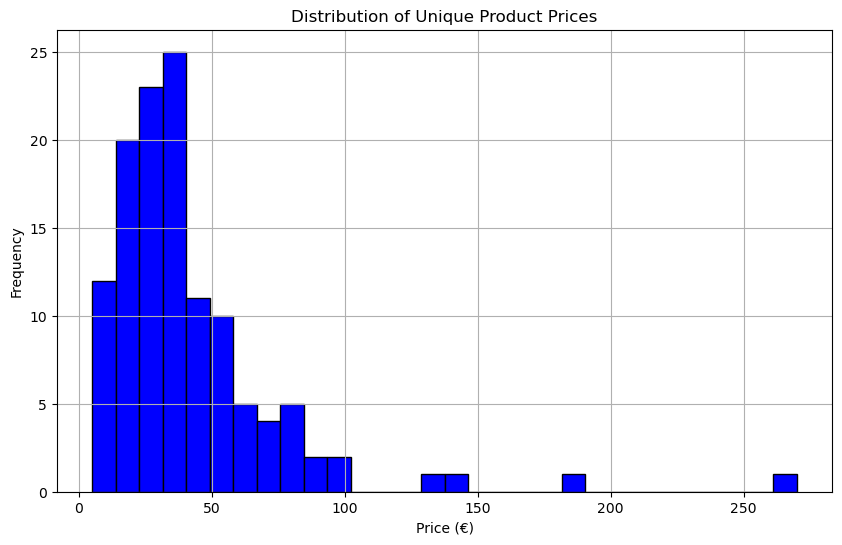

In [248]:
# Aggregate and plot the distribution of prices for unique products
unique_product_prices = master_df.groupby('product_name')['price'].mean().reset_index()

# Plot the corrected distribution of prices
plt.figure(figsize=(10, 6))
plt.hist(unique_product_prices['price'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Unique Product Prices')
plt.xlabel('Price (€)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

##### We observe that most unique products are priced under €50, with the majority concentrated between €10 and €40.
##### There are a few higher-priced products above €100, but they are rare

In [249]:
# Calculate percentiles for the unique product prices to help define thresholds
percentiles = unique_product_prices['price'].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
percentiles

0.10     13.92
0.25     22.00
0.50     35.00
0.75     49.90
0.90     76.60
0.95     91.80
0.99    173.86
Name: price, dtype: float64

In [250]:
# Define the calculated percentiles from the unique product prices for use on the main dataset
low_threshold = unique_product_prices['price'].quantile(0.25)  # 25th percentile
medium_threshold = unique_product_prices['price'].quantile(0.75)  # 75th percentile

# Apply the categorization function to the main dataset
def categorize_price_main(price):
    if price < low_threshold:
        return "Low"
    elif low_threshold <= price <= medium_threshold:
        return "Medium"
    else:
        return "High"

# Add the price category feature to the main dataset
master_df['price_category'] = master_df['price'].apply(categorize_price_main)

In [251]:
# Display the updated main dataset to verify the new feature
master_df[['product_name', 'price', 'price_category']].tail()

,product_name,price,price_category
2376,Soin anti-imperfections à l'acide succinique,11.9,Low
2377,Soin anti-imperfections à l'acide succinique,11.9,Low
2378,Soin anti-imperfections à l'acide succinique,11.9,Low
2379,Soin anti-imperfections à l'acide succinique,11.9,Low
2380,Soin anti-imperfections à l'acide succinique,11.9,Low


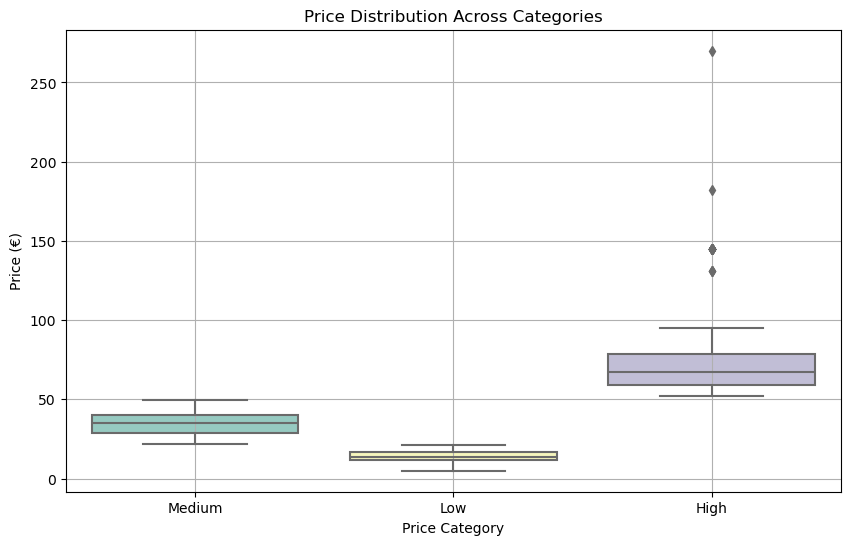

In [252]:
# Visualize price distribution across price categories
plt.figure(figsize=(10, 6))
sns.boxplot(data=master_df, x='price_category', y='price', palette='Set3')
plt.title('Price Distribution Across Categories')
plt.xlabel('Price Category')
plt.ylabel('Price (€)')
plt.grid(True)
plt.show()

##### Price Distribution Across Categories
This box plot visualizes the distribution of product prices within each price category: **Low, Medium, and High**.
* Low Category: The prices are tightly clustered at the lower end, as expected.
* Medium Category: Has a broader range, showing more variability in product pricing.
* High Category: Prices are higher, with a few outliers that indicate premium products.

##### Checking for the distribuation of total nb of reviews

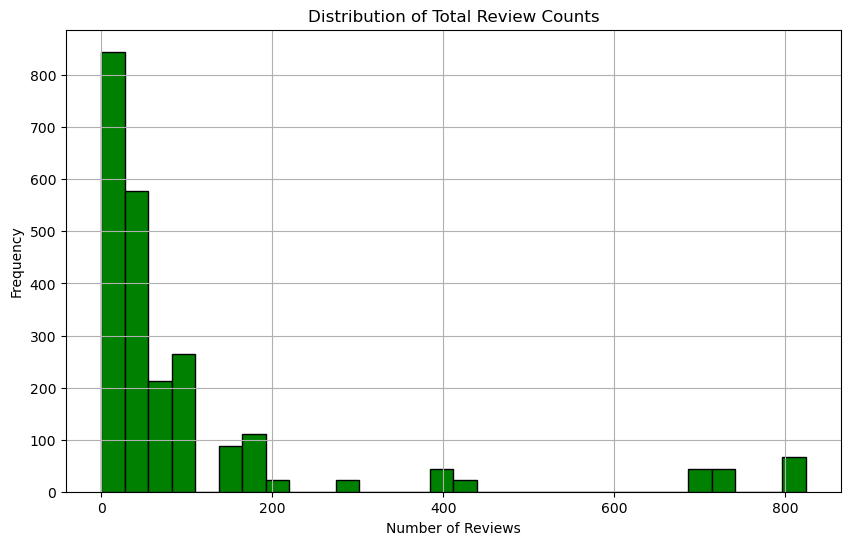

In [253]:
# Visualize the distribution of total review counts to determine a popularity threshold
plt.figure(figsize=(10, 6))
plt.hist(master_df['total_review_count'], bins=30, color='green', edgecolor='black')
plt.title('Distribution of Total Review Counts')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

##### Right-skewed distribution
##### The majority of products have fewer than 100 reviews; There are a few products with review counts significantly higher

In [254]:
# Choosing the Relevant Thresholds

# Calculate percentiles of total review counts to help decide on popularity thresholds
percentiles_review_count = master_df['total_review_count'].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

# Display the calculated percentiles
percentiles_review_count

0.10     11.0
0.25     19.0
0.50     41.0
0.75    103.0
0.90    291.0
0.95    708.0
0.99    824.0
Name: total_review_count, dtype: float64

In [255]:
# Define the thresholds for the popularity categories based on the percentiles
def assign_popularity_category(review_count):
    if review_count < 11:
        return "Low Popularity"
    elif 11 <= review_count <= 40:
        return "Moderate Popularity"
    elif 41 <= review_count <= 100:
        return "High Popularity"
    else:
        return "Very High Popularity"

##### popularity_category Feature

In [256]:
# Apply the function to create a new column 'popularity_category' in the main dataset
master_df['popularity_category'] = master_df['total_review_count'].apply(assign_popularity_category)

# Display a sample of the updated dataset to verify the new feature
master_df[['product_name', 'total_review_count', 'popularity_category']].head()

,product_name,total_review_count,popularity_category
0,Disques Eclat du Visage - Soin aux Acides Glyc...,14,Moderate Popularity
1,Disques Eclat du Visage - Soin aux Acides Glyc...,14,Moderate Popularity
2,Disques Eclat du Visage - Soin aux Acides Glyc...,14,Moderate Popularity
3,Disques Eclat du Visage - Soin aux Acides Glyc...,14,Moderate Popularity
4,Disques Eclat du Visage - Soin aux Acides Glyc...,14,Moderate Popularity


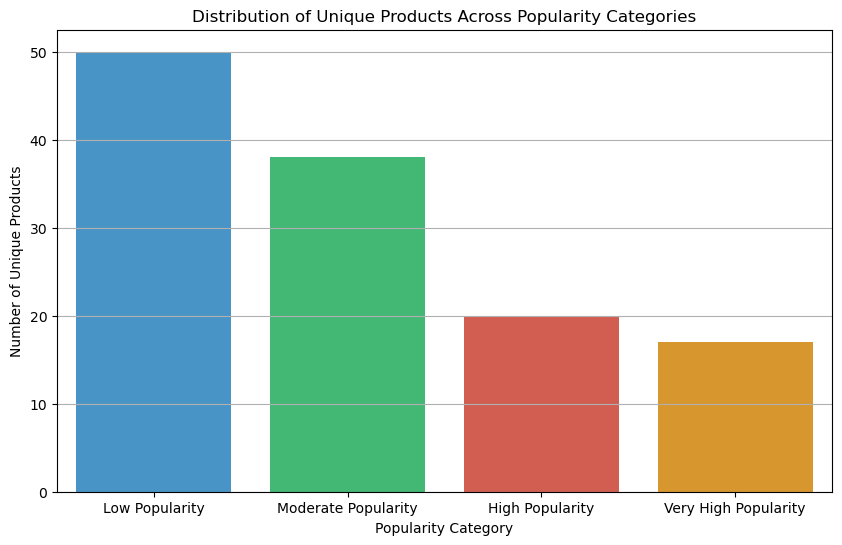

In [257]:
# Ensure to only count unique products for popularity distribution ( Aggregate to get unique products based on their popularity category)
unique_products = master_df[['product_name', 'popularity_category']].drop_duplicates()

# Visualize the distribution of unique products across popularity categories with custom colors
plt.figure(figsize=(10, 6))
sns.countplot(
    data=unique_products, 
    x='popularity_category', 
    palette=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'],  # Custom colors: blue, green, red, orange
    order=['Low Popularity', 'Moderate Popularity', 'High Popularity', 'Very High Popularity']
)
plt.title('Distribution of Unique Products Across Popularity Categories')
plt.xlabel('Popularity Category')
plt.ylabel('Number of Unique Products')
plt.grid(True, axis='y')
plt.show()

###### Popularity Distribution Across Categories
This bar chart visualizes the distribution of **unique products** within each popularity category:

- **Low Popularity**: The largest group, indicating that many products have relatively low engagement with fewer than 11 reviews. This could mean there is a large selection of niche products or newer entries that haven't gained traction yet.
- **Moderate Popularity**: A smaller segment than Low Popularity, suggesting that a moderate number of products have gained some attention but are not particularly popular.
- **High Popularity**: Even fewer products fall into this category, indicating that it is challenging for products to reach this level of engagement (between 41 and 100 reviews).
- **Very High Popularity**: The smallest category, showing that only a select few products achieve very high popularity (100+ reviews), possibly due to brand loyalty, effective marketing, or standout features.

This distribution helps to understand how engagement is spread across products. The large proportion of **Low Popularity** products suggests that either the market is fragmented or there are many products that haven't been widely discovered by customers. Focusing on what makes the **Very High Popularity** products successful could provide insights into effective strategies for boosting engagement.

* This interpretation draws attention to the dominance of low-engagement products and the rarity of very popular ones, encouraging deeper analysis into why this might be the case.
* Highlighting the "Very High Popularity" products can lead to insights on what drives success.

##### relative_price Feature

In [258]:
# Calculate the average price per brand
brand_avg_price = master_df.groupby('brand')['price'].mean().reset_index()
brand_avg_price.columns = ['brand', 'avg_brand_price']

In [259]:
brand_avg_price.head()

,brand,avg_brand_price
0,AESOP,55.000
1,AUGUSTINUS BADER,95.000
2,BELIF,39.900
3,BENEFIT COSMETICS,37.675
4,BIODERMA,14.625


In [260]:
# Merge this average price back into the main dataset
master_df = master_df.merge(brand_avg_price, on='brand', how='left')

# Calculate the relative price as the ratio of the product price to the average brand price
master_df['relative_price'] = master_df['price'] / master_df['avg_brand_price']

# Drop 'avg_brand_price' 
# master_df.drop(columns=['avg_brand_price'], inplace=True)

In [261]:
# Verify the new feature
master_df[['product_name', 'brand', 'price', 'avg_brand_price', 'relative_price']].tail()

,product_name,brand,price,avg_brand_price,relative_price
2357,Soin anti-imperfections à l'acide succinique,THE INKEY LIST,11.9,12.733333,0.934555
2358,Soin anti-imperfections à l'acide succinique,THE INKEY LIST,11.9,12.733333,0.934555
2359,Soin anti-imperfections à l'acide succinique,THE INKEY LIST,11.9,12.733333,0.934555
2360,Soin anti-imperfections à l'acide succinique,THE INKEY LIST,11.9,12.733333,0.934555
2361,Soin anti-imperfections à l'acide succinique,THE INKEY LIST,11.9,12.733333,0.934555


Relative Price Feature:

* A relative_price greater than 1 means the product is priced higher than the brand's average, indicating it might be a premium product within that brand.
* A relative_price less than 1 means the product is priced lower than the brand's average, suggesting it could be a budget-friendly or entry-level option within that brand.

##### Days Since Last Review

In [262]:
# Calculate the days since the last review by comparing to the current date
master_df['days_since_last_review'] = (datetime.now() - master_df['date']).dt.days

In [263]:
# Verify the new feature
master_df[['product_name', 'date', 'days_since_last_review']].head()

,product_name,date,days_since_last_review
0,Disques Eclat du Visage - Soin aux Acides Glyc...,2024-01-19,273.0
1,Disques Eclat du Visage - Soin aux Acides Glyc...,2023-12-09,314.0
2,Disques Eclat du Visage - Soin aux Acides Glyc...,2023-12-09,314.0
3,Disques Eclat du Visage - Soin aux Acides Glyc...,2023-12-01,322.0
4,Disques Eclat du Visage - Soin aux Acides Glyc...,2023-11-23,330.0


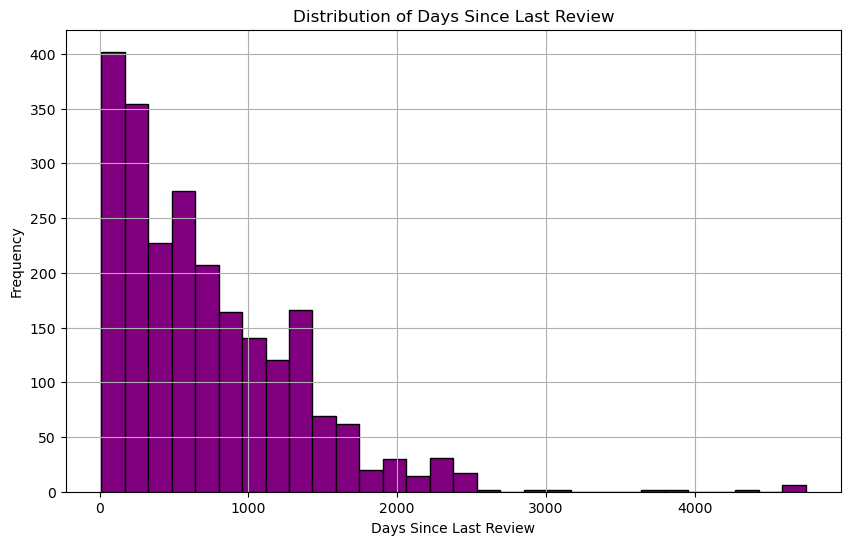

In [264]:
# Visualize the distribution of days since the last review
plt.figure(figsize=(10, 6))
plt.hist(master_df['days_since_last_review'].dropna(), bins=30, color='purple', edgecolor='black')
plt.title('Distribution of Days Since Last Review')
plt.xlabel('Days Since Last Review')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

##### Distribution of Days Since Last Review
This histogram illustrates how many days have passed since the last review for each product:

- **Recent Reviews (Left Side)**: A significant number of products have been reviewed within the last few days, indicating they are currently popular or recently launched.
- **Older Reviews (Right Side)**: There are also products that haven’t been reviewed for over 1000 days, suggesting they may be less relevant, out of stock, or less popular now.

**Relevance**:
This distribution helps identify which products are maintaining consistent customer engagement and which ones may need marketing support or could be candidates for discontinuation. Products with recent reviews can also indicate current trends and consumer interests.

##### Visualize Key Metrics for Top Brands (review higher 4.8)

In [223]:
# Identify top brands by average overall rating greater than 4.8
top_brands = master_df.groupby('brand')['overall_rating'].mean()
top_brands = top_brands[top_brands > 4.8].index

# Filter dataset for these top brands
top_brands_data = master_df[master_df['brand'].isin(top_brands)]

# Verify the brands selected
print(top_brands)

Index(['BOBBI BROWN', 'DIOR', 'DR DENNIS GROSS', 'FIRST AID BEAUTY',
       'INSTITUT ESTHEDERM', 'ON THE WILD SIDE', 'UNBOTTLED'],
      dtype='object', name='brand')


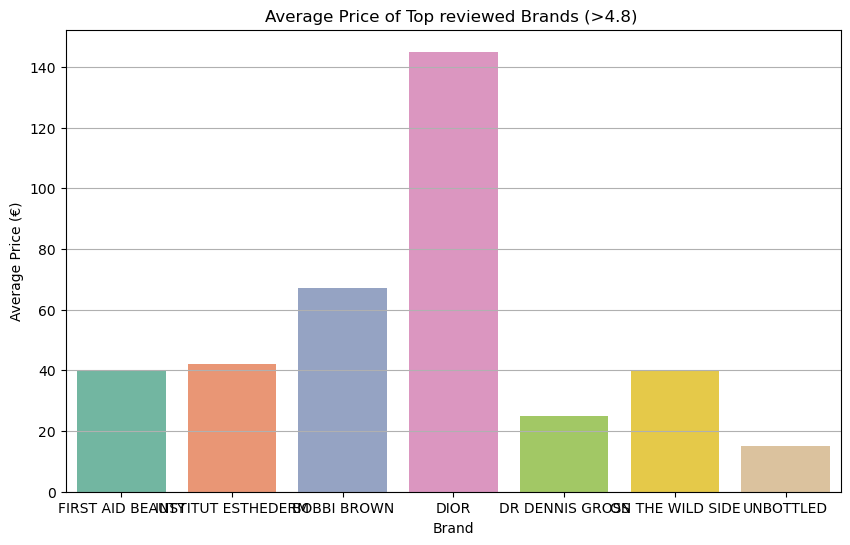

In [228]:
# Plot average price per top brand
plt.figure(figsize=(10, 6))
sns.barplot(data=top_brands_data, x='brand', y='price', estimator='mean', palette='Set2')
plt.title('Average Price of Top reviewed Brands (>4.8) ')
plt.xlabel('Brand')
plt.ylabel('Average Price (€)')
plt.grid(True, axis='y')
plt.show()

### Average Price of Top Reviewed Brands (>4.8)
This bar chart shows the **average price** of products for brands with an average rating greater than 4.8:

- **Dior**: Stands out with a significantly higher average price compared to other top-rated brands. This suggests Dior positions its products as premium, which aligns with its brand image.
- **Bobbi Brown and Dr. Dennis Gross**: Have mid-range pricing, indicating a balance between affordability and quality.
- **Institut Esthederm and First Aid Beauty**: Feature lower average prices, suggesting they are more accessible while maintaining high ratings.


This graph provides insights into **pricing strategies** for highly rated brands. Understanding how these brands position themselves in terms of price can help identify market segments and potential gaps. For instance, if a brand is both highly rated and lower priced, it may have tapped into an effective strategy of delivering quality at an affordable rate.


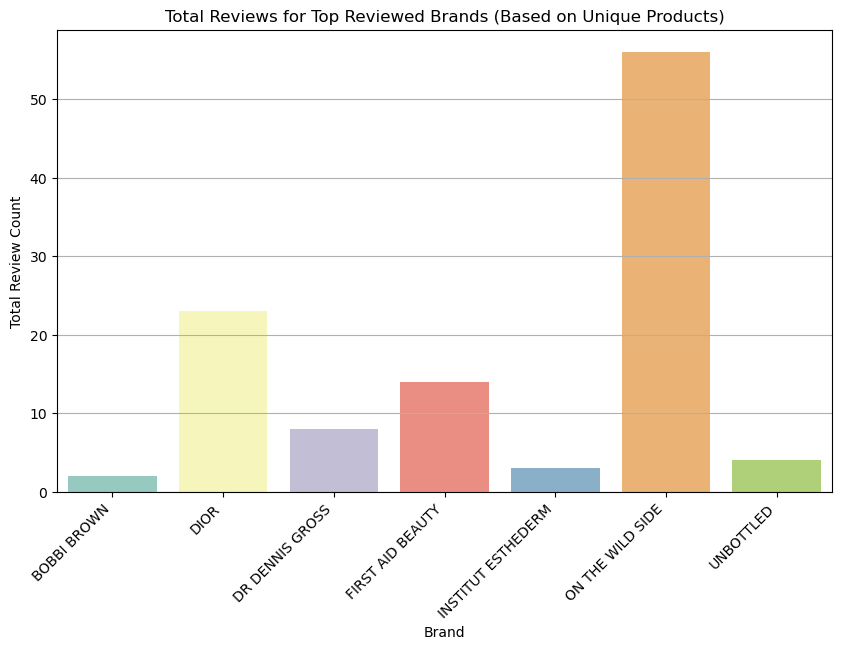

In [273]:
# Aggregate to get unique products with their total review counts
unique_products = top_brands_data[['product_name', 'brand', 'total_review_count']].drop_duplicates()

# Sum the total reviews per brand based on unique products
brand_review_summary = unique_products.groupby('brand')['total_review_count'].sum().reset_index()

# Plot the corrected total reviews per top brand
plt.figure(figsize=(10, 6))
sns.barplot(data=brand_review_summary, x='brand', y='total_review_count', palette='Set3')
plt.title('Total Reviews for Top Reviewed Brands (Based on Unique Products)')
plt.xlabel('Brand')
plt.ylabel('Total Review Count')
plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees and align to the right for better readability
plt.grid(True, axis='y')
plt.show()

### Total Reviews for Top Reviewed Brands
This bar chart represents the **total number of reviews** for each top-rated brand, ensuring that each product’s review count is only considered once. This adjustment prevents inflated review counts due to multiple entries for the same product.

**Key Insights**:
1. **On The Wild Side**:
   - Dominates with the highest total review count, indicating strong customer engagement for its products. This suggests effective marketing and brand loyalty, even if the brand might have fewer products overall.
   
2. **Dior**:
   - Shows significant engagement with over 20 total reviews, suggesting that its products maintain popularity despite a likely premium price range. This indicates a balance between luxury branding and consistent quality.

3. **First Aid Beauty** & **Dr. Dennis Gross**:
   - These brands have moderate review counts, reflecting a stable yet potentially niche audience. This may imply targeted marketing or appeal to a specific customer base.

4. **Bobbi Brown & Institut Esthederm**:
   - While maintaining high ratings, these brands have fewer reviews, suggesting they may be more niche or have less market reach. There’s potential for growth if they can enhance visibility and brmarket presence.


<Figure size 1200x800 with 0 Axes>

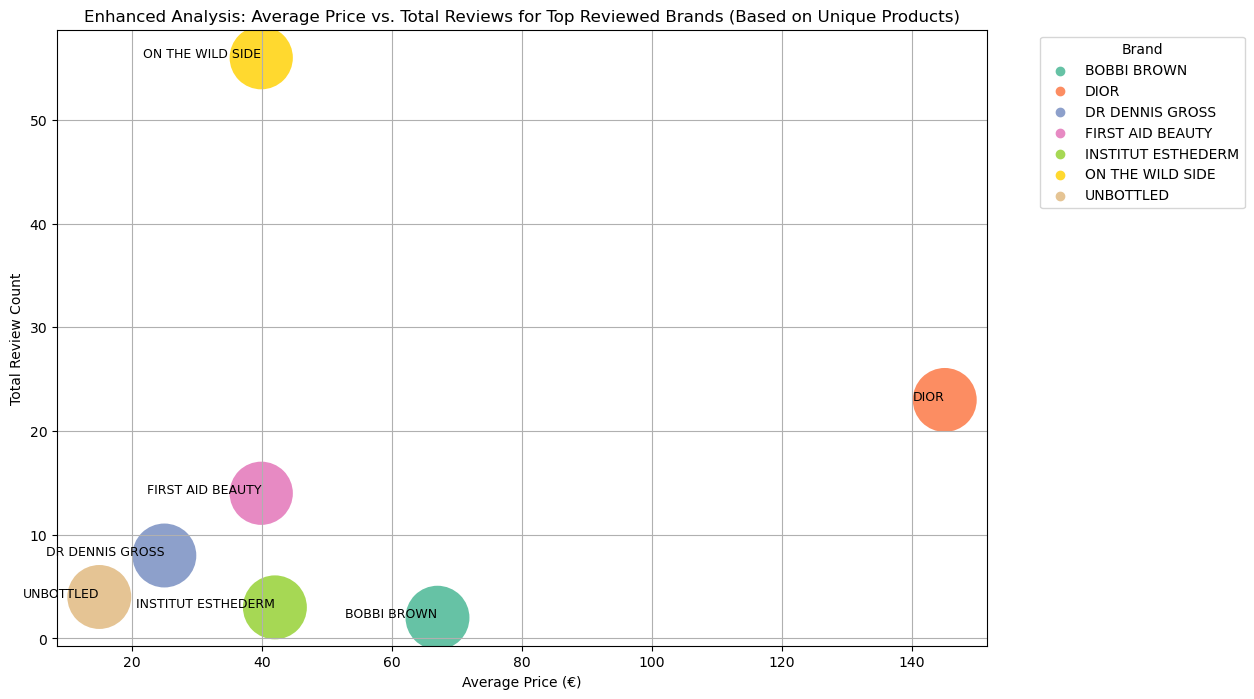

In [275]:
# Create a scatter plot 
plt.figure(figsize=(12, 8))

# Calculate average price and total reviews based on unique products
brand_avg = unique_products.groupby('brand').agg({
    'total_review_count': 'sum',  # Total reviews based on unique products
    'product_name': 'count',  # Total number of unique products
}).reset_index()

# Calculate average price and average overall rating per brand using the original data
brand_price_rating = top_brands_data.groupby('brand').agg({
    'price': 'mean', 
    'overall_rating': 'mean'
}).reset_index()

# Merge dataframes to get complete brand information
brand_avg = pd.merge(brand_avg, brand_price_rating, on='brand')

# Scale point size based on average overall rating (optional, adjust as needed)
point_sizes = brand_avg['overall_rating'] * 500

# Step 3: Create the scatter plot with enhanced features
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=brand_avg, 
    x='price', 
    y='total_review_count', 
    hue='brand', 
    s=point_sizes,  # Adjust size based on ratings
    palette='Set2'
)

# Add brand name labels directly to the points for clarity
for i in range(brand_avg.shape[0]):
    plt.text(
        brand_avg['price'][i], 
        brand_avg['total_review_count'][i], 
        brand_avg['brand'][i], 
        fontsize=9, 
        ha='right'
    )

plt.title('Enhanced Analysis: Average Price vs. Total Reviews for Top Reviewed Brands (Based on Unique Products)')
plt.xlabel('Average Price (€)')
plt.ylabel('Total Review Count')
plt.grid(True)
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
plt.show()


### Enhanced Analysis: Average Price vs. Total Reviews for Top Reviewed Brands (Based on Unique Products)
This scatter plot provides a **comprehensive view** by linking **average price**, **total reviews**, and **brand popularity** across top-rated brands, based on **unique products**. Each point represents a brand, with the **size** of the points indicating the **average overall rating**.

**Key Insights**:
1. **Premium Positioning with High Engagement**:
   - **Dior** stands out on the far right with the highest **average price** and strong **total reviews**, reflecting **brand loyalty** that balances **luxury** with consistent customer appeal.
   - **Point Size**: Dior's large point size confirms its **high average ratings**, supporting its premium image.

2. **High Engagement Through Affordability**:
   - **On The Wild Side** achieves the highest **total review count** at a **lower average price** compared to Dior. This suggests a focus on **value-driven marketing** and broader accessibility.
   - Despite its lower pricing, it maintains **high ratings**, indicating that affordability does not compromise quality.

3. **Mid-Tier Brands with Niche Appeal**:
   - **First Aid Beauty**: Balances **moderate pricing** with steady engagement, appealing to customers seeking quality without premium prices.
   - **Bobbi Brown, Dr. Dennis Gross, and Institut Esthederm**: Show **limited engagement** despite competitive pricing, suggesting the need for stronger marketing or broader outreach.

4. **Opportunities for Growth**:
   - **Unbottled and Dr. Dennis Gross**: With **lower prices** but fewer reviews, these brands could benefit from **increased visibility** and **targeted campaigns** to expand thesthederm, Unbottled).
nced marketing efforts**.


By combining these three metrics—**average price**, **total reviews**, and **average ratings**—this analysis provides a nuanced understanding of **brand strategies**:
- Premium brands can **leverage loyalty** despite high prices (e.g., Dior).
- Affordable brands can achieve **high engagement** (e.g., On The Wild Side).
- Niche brands need to **build visibility** to grow engagement while maintaining high customer satisfaction (e.g., Institut Esthederm, Unbottled).

In [278]:
master_df.head()

,product_name,brand,price,variation_qty,total_review_count,overall_rating,reviewer_name,age,sex,date,...,title,review_description,recommendation,url,is_overall_rated,price_category,popularity_category,avg_brand_price,relative_price,days_since_last_review
0,Disques Eclat du Visage - Soin aux Acides Glyc...,FIRST AID BEAUTY,39.9,60 disques,14,4.9,Danuniverse,25-34,Not Defined,2024-01-19,...,Parfait,Ces disques sont un jeu-changer pour ma routin...,Oui,https://www.sephora.fr/p/disques-eclat-du-visa...,1,Medium,Moderate Popularity,39.9,1.0,273.0
1,Disques Eclat du Visage - Soin aux Acides Glyc...,FIRST AID BEAUTY,39.9,60 disques,14,4.9,Willy,Not Defined,Homme,2023-12-09,...,J’aime beaucoup !,"Les disques démaquillant, nettoyant que j’ai a...",No response,https://www.sephora.fr/p/disques-eclat-du-visa...,1,Medium,Moderate Popularity,39.9,1.0,314.0
2,Disques Eclat du Visage - Soin aux Acides Glyc...,FIRST AID BEAUTY,39.9,60 disques,14,4.9,Willy,Not Defined,Homme,2023-12-09,...,Top,"J’ai disque démaquillant, nettoyant que j’ai r...",Oui,https://www.sephora.fr/p/disques-eclat-du-visa...,1,Medium,Moderate Popularity,39.9,1.0,314.0
3,Disques Eclat du Visage - Soin aux Acides Glyc...,FIRST AID BEAUTY,39.9,60 disques,14,4.9,Sassouh34,25-34,Not Defined,2023-12-01,...,Efficace et pratique,"Format très pratiques , ces disques prêts à l'...",Oui,https://www.sephora.fr/p/disques-eclat-du-visa...,1,Medium,Moderate Popularity,39.9,1.0,322.0
4,Disques Eclat du Visage - Soin aux Acides Glyc...,FIRST AID BEAUTY,39.9,60 disques,14,4.9,Laeti,35-44,Not Defined,2023-11-23,...,Mes chouchou,"Alors là c’est un de mes produits chouchou, j’...",Oui,https://www.sephora.fr/p/disques-eclat-du-visa...,1,Medium,Moderate Popularity,39.9,1.0,330.0


##### Setiment Analysis: 

In [279]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to analyze sentiment
def analyze_sentiment(review):
    # Translate to English for more reliable sentiment analysis
    try:
        blob = TextBlob(str(review))
        sentiment = blob.sentiment.polarity  # Polarity ranges from -1 (negative) to 1 (positive)
        if sentiment > 0:
            return 'Positive'
        elif sentiment == 0:
            return 'Neutral'
        else:
            return 'Negative'
    except:
        return 'Neutral'

# Apply sentiment analysis to the review descriptions
master_df['sentiment'] = master_df['review_description'].apply(analyze_sentiment)

# Aggregate sentiment counts per brand
brand_sentiment_summary = master_df.groupby('brand')['sentiment'].value_counts(normalize=True).unstack().fillna(0) * 100

In [280]:
# Display the processed sentiment analysis summary for quick verification
brand_sentiment_summary.head()

sentiment,Negative,Neutral,Positive
brand,,,
AESOP,0.000000,100.000000,0.000000
AUGUSTINUS BADER,0.000000,7.692308,92.307692
BELIF,7.142857,64.285714,28.571429
BENEFIT COSMETICS,2.272727,78.409091,19.318182
BIODERMA,0.000000,25.000000,75.000000


<Figure size 1200x600 with 0 Axes>

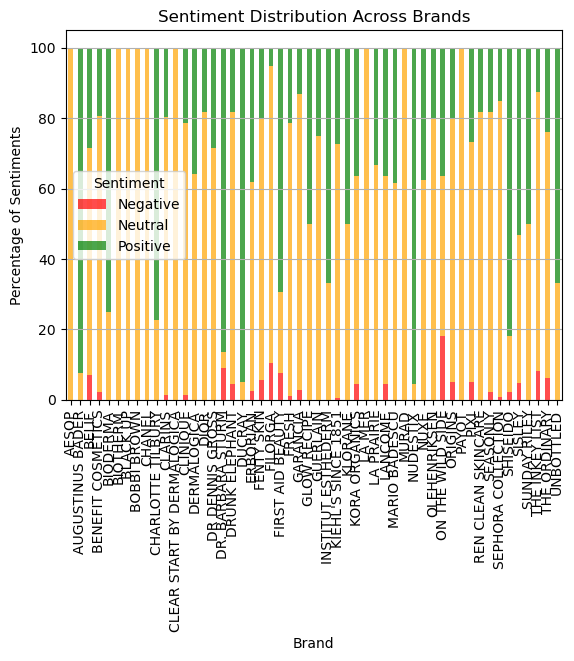

In [281]:
# Visualize the sentiment distribution across brands
plt.figure(figsize=(12, 6))
brand_sentiment_summary.plot(kind='bar', stacked=True, color=['red', 'orange', 'green'], alpha=0.7)
plt.title('Sentiment Distribution Across Brands')
plt.xlabel('Brand')
plt.ylabel('Percentage of Sentiments')
plt.legend(title='Sentiment')
plt.grid(True, axis='y')
plt.show()

In [284]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:


# Function to get common keywords from reviews
def get_common_keywords(df, sentiment, num_words=10):
    reviews = df[df['sentiment'] == sentiment]['review_description'].dropna()
    vectorizer = CountVectorizer(stop_words='french', max_features=1000)
    X = vectorizer.fit_transform(reviews)
    keywords = vectorizer.get_feature_names_out()
    word_counts = X.toarray().sum(axis=0)
    most_common = Counter(dict(zip(keywords, word_counts))).most_common(num_words)
    return dict(most_common)

# Get common keywords for each sentiment
positive_keywords = get_common_keywords(df, 'Positive', 15)
negative_keywords = get_common_keywords(df, 'Negative', 15)

# Visualize as Word Clouds for better clarity
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
positive_cloud = WordCloud(background_color='white').generate_from_frequencies(positive_keywords)
negative_cloud = WordCloud(background_color='white', colormap='Reds').generate_from_frequencies(negative_keywords)

ax[0].imshow(positive_cloud, interpolation='bilinear')
ax[0].set_title('Positive Sentiment Keywords')
ax[0].axis('off')

ax[1].imshow(negative_cloud, interpolation='bilinear')
ax[1].set_title('Negative Sentiment Keywords')
ax[1].axis('off')

plt.show()


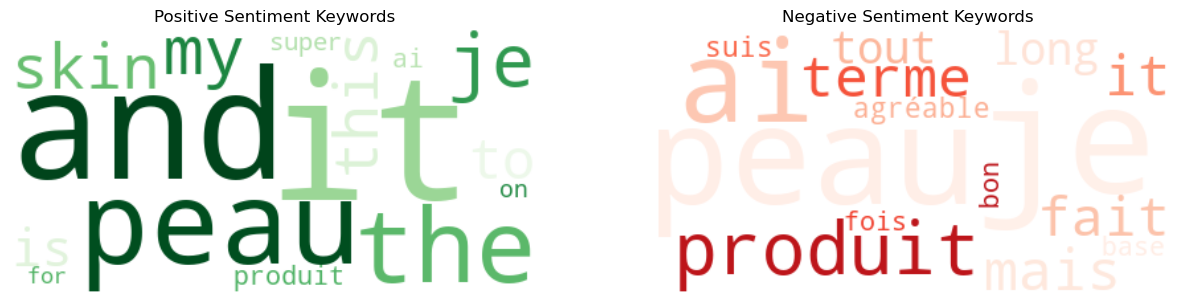

({'it': 555,
  'and': 532,
  'peau': 526,
  'the': 475,
  'je': 450,
  'my': 381,
  'skin': 347,
  'this': 327,
  'to': 266,
  'is': 224,
  'produit': 210,
  'ai': 208,
  'super': 177,
  'on': 163,
  'for': 151},
 {'je': 95,
  'peau': 77,
  'ai': 50,
  'produit': 34,
  'mais': 20,
  'terme': 20,
  'it': 19,
  'fait': 18,
  'long': 18,
  'tout': 18,
  'agréable': 17,
  'suis': 17,
  'base': 16,
  'bon': 16,
  'fois': 16})

In [285]:
# Define a basic list of French stop words to use
french_stop_words = [
    'le', 'la', 'les', 'de', 'des', 'du', 'et', 'en', 'un', 'une', 'à', 'pour', 'avec', 'par', 
    'dans', 'ce', 'cette', 'ces', 'mon', 'ma', 'mes', 'son', 'sa', 'ses', 'sur', 'au', 'aux', 
    'qui', 'que', 'quoi', 'dont', 'elle', 'il', 'ils', 'elles', 'nous', 'vous', 'y', 'ne', 'pas', 
    'plus', 'moins', 'bien', 'très', 'se', 'est', 'sont', 'été', 'être', 'avoir', 'faire', 'comme', 
    'si', 'ou', 'oui', 'non', 'ça', 'car', 'chez', 'cet', 'cette', 'aussi', 'me', 'te', 'lui', 'leur'
]

# Adjust the keyword extraction function to include these stop words
def extract_keywords_with_custom_stopwords(sentiment_type, num_words=15):
    # Extract reviews of the specified sentiment type
    reviews = master_df[master_df['sentiment'] == sentiment_type]['review_description'].dropna()
    
    # Use CountVectorizer to get common words, including custom French stop words
    vectorizer = CountVectorizer(stop_words=french_stop_words, max_features=1000)
    X = vectorizer.fit_transform(reviews)
    keywords = vectorizer.get_feature_names_out()
    word_counts = X.toarray().sum(axis=0)
    
    # Get the most common words
    most_common = Counter(dict(zip(keywords, word_counts))).most_common(num_words)
    return dict(most_common)

# Extract positive and negative keywords
positive_keywords = extract_keywords_with_custom_stopwords('Positive', 15)
negative_keywords = extract_keywords_with_custom_stopwords('Negative', 15)

# Generate word clouds for visual representation
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Positive sentiment word cloud
positive_cloud = WordCloud(background_color='white', colormap='Greens').generate_from_frequencies(positive_keywords)
ax[0].imshow(positive_cloud, interpolation='bilinear')
ax[0].set_title('Positive Sentiment Keywords')
ax[0].axis('off')

# Negative sentiment word cloud
negative_cloud = WordCloud(background_color='white', colormap='Reds').generate_from_frequencies(negative_keywords)
ax[1].imshow(negative_cloud, interpolation='bilinear')
ax[1].set_title('Negative Sentiment Keywords')
ax[1].axis('off')

plt.show()

# Output the extracted keywords for further insights
positive_keywords, negative_keywords


## Second Method for sentiment analysis

In [286]:
pip install deep-translator

  Obtaining dependency information for deep-translator from https://files.pythonhosted.org/packages/38/3f/61a8ef73236dbea83a1a063a8af2f8e1e41a0df64f122233938391d0f175/deep_translator-1.11.4-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/42.3 kB ? eta -:--:--
   ----------------------------- ---------- 30.7/42.3 kB 640.0 kB/s eta 0:00:01
   ---------------------------------------- 42.3/42.3 kB 681.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [287]:
from textblob import TextBlob
from deep_translator import GoogleTranslator

# Function to refine sentiment classification using translation and deeper analysis
def enhanced_sentiment_analysis(text):
    """
    Translate the review to English (if in French), then analyze sentiment.
    This helps in capturing subtle positive/negative expressions.
    """
    try:
        # Translate text to English
        translated_text = GoogleTranslator(source='auto', target='en').translate(text)
        # Analyze translated text sentiment
        blob = TextBlob(translated_text)
        # Classify based on polarity: positive (>0), neutral (0), negative (<0)
        if blob.sentiment.polarity > 0:
            return "Positive"
        elif blob.sentiment.polarity < 0:
            return "Negative"
        else:
            return "Neutral"
    except Exception as e:
        return "Neutral"  # Default to neutral in case of an error

# Apply the refined sentiment analysis to the dataset
master_df['enhanced_sentiment'] = master_df['review_description'].apply(enhanced_sentiment_analysis)

# Re-run sentiment distribution analysis to check if there are improvements
sentiment_counts = master_df['enhanced_sentiment'].value_counts(normalize=True) * 100

# Return the updated sentiment distribution
sentiment_counts

enhanced_sentiment
Positive    84.250635
Negative     9.356478
Neutral      6.392887
Name: proportion, dtype: float64

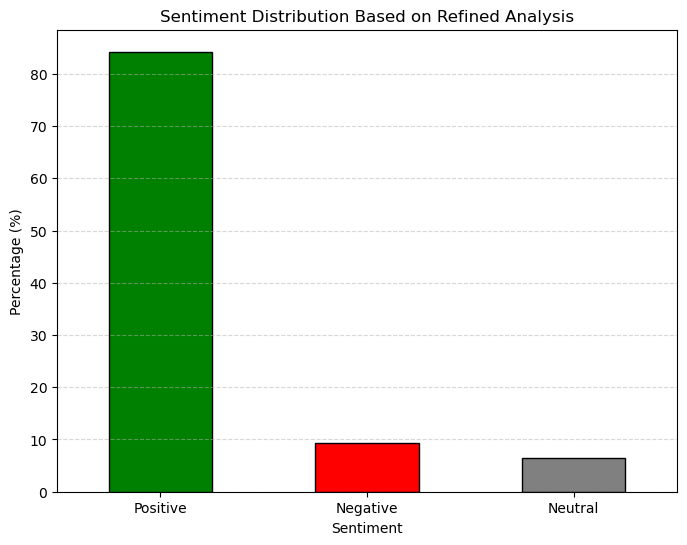

In [288]:
import matplotlib.pyplot as plt

# Visualize the sentiment distribution as a bar chart
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'gray'], edgecolor='black')
plt.title('Sentiment Distribution Based on Refined Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


<Figure size 1000x600 with 0 Axes>

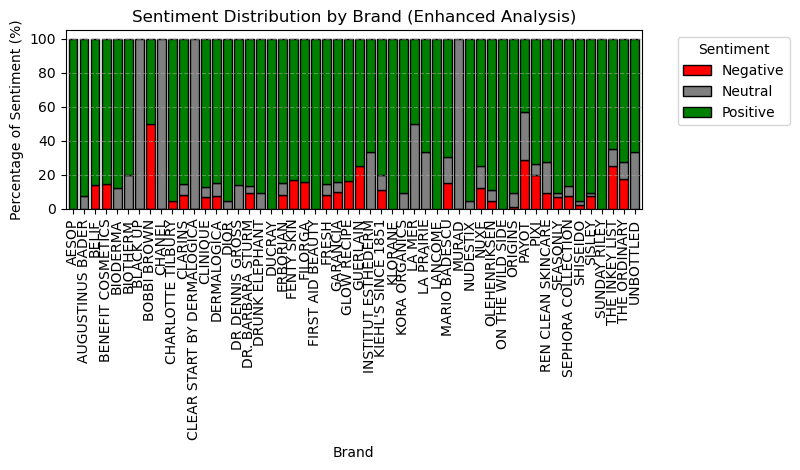

In [324]:
plt.figure(figsize=(10, 6))  

# Create the stacked bar chart
brand_sentiment_percentage.plot(kind='bar', stacked=True, width=0.8, color=['red', 'gray', 'green'], edgecolor='black')

plt.title('Sentiment Distribution by Brand (Enhanced Analysis)')
plt.xlabel('Brand')
plt.ylabel('Percentage of Sentiment (%)')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90, ha='center')  # Rotate labels vertically
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.95)  # Add padding for better layout
plt.show()


### Sentiment Distribution by Brand 

This stacked bar chart visualizes the **distribution of customer sentiments** across brands, segmented into **positive (green)**, **neutral (gray)**, and **negative (red)** sentiments.

#### Key Insights:
1. **Overall Positive Feedback**:
   - Most brands show **high percentages of positive reviews**, indicating strong customer satisfaction. 
   - **Brands like Aesop, Drunk Elephant, and The Inkey List** maintain particularly high positive reception, reflecting effective product quality.

2. **Brands with Mixed Feedback**:
   - **Bobbi Brown and The Ordinary** show more **negative and neutral** sentiment, suggesting **mixed customer experiences**. Addressing specific feedback could improve customer satisfaction.
   - **On The Wild Side** also has a higher proportion of neutral feedback, indicating possible areas for **product improvement**.

This analysis highlights **brand strengths and areas needing attention**, aiding in **data-driven decisions** to improve customer engagement and product strategies.


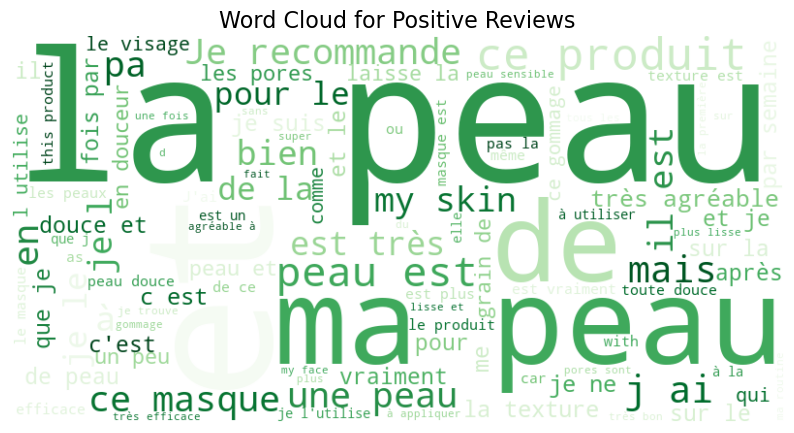

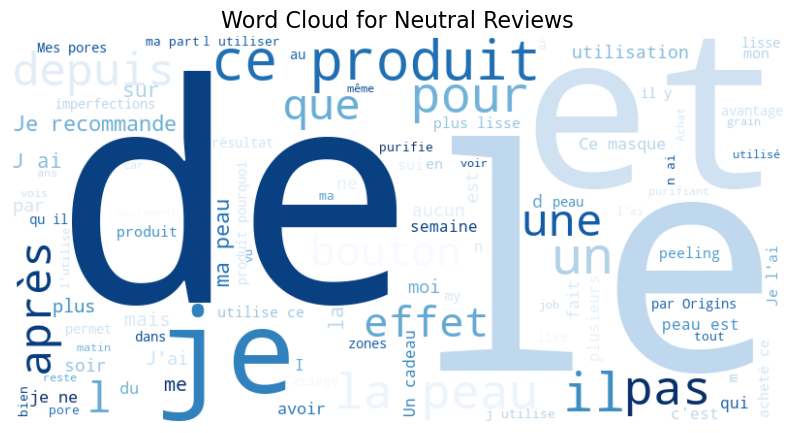

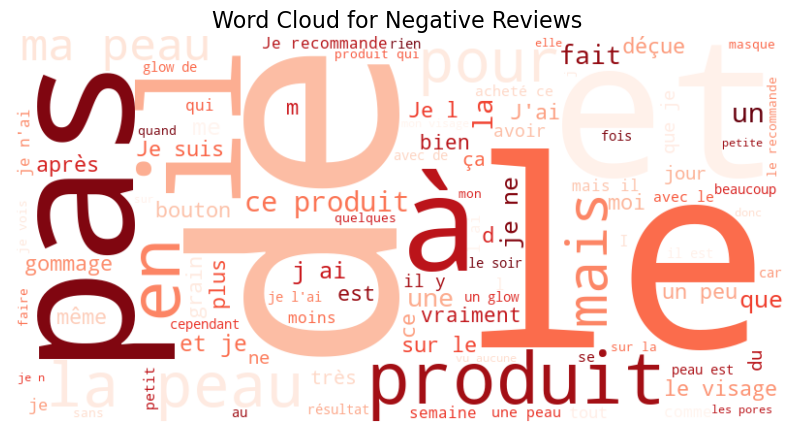

In [326]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Updated function to handle NaN values
def generate_wordcloud(data, sentiment_label, color):
    """
    Generates a word cloud for a given sentiment label.
    
    :param data: DataFrame containing the data
    :param sentiment_label: The sentiment label to filter (e.g., 'Positive')
    :param color: Color scheme for the word cloud
    """
    # Convert to string and handle missing values
    sentiment_text = ' '.join(data[data['enhanced_sentiment'] == sentiment_label]['review_description'].fillna('').astype(str))
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color, 
                          max_words=100, stopwords={'the', 'and', 'to', 'of', 'in', 'for', 'a', 'is', 'it', 'on'}).generate(sentiment_text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment_label} Reviews', fontsize=16)
    plt.show()

# Generate word clouds for each sentiment
generate_wordcloud(master_df, 'Positive', 'Greens')
generate_wordcloud(master_df, 'Neutral', 'Blues')
generate_wordcloud(master_df, 'Negative', 'Reds')


In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline

# Load data
data = pd.read_excel('sephore_product_data_file.xlsx')

# Preprocessing steps
data['extracted_rating'] = data['overall_rating'].str.extract(r'(\d+\.\d+)').fillna(0).astype(float)
data['rating'] = data['rating'].str.extract(r'(\d+)/').fillna(0).astype(int)
data['age'] = data['age'].str.replace(r' ans', '')
data['price'] = data['price'].str.replace(',', '.').str.extract('(\d+\.\d+)').astype(float)

# Fill missing review descriptions with an empty string
data['review_description'] = data['review_description'].fillna('')

# Sentiment Analysis
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Apply sentiment analysis safely
def analyze_sentiment(text):
    try:
        return sentiment_pipeline(text)[0]['label']
    except Exception as e:
        print(f"Error processing text: {text}. Error: {e}")
        return '3 stars'  # Default value if sentiment analysis fails

data['sentiment'] = data['review_description'].apply(analyze_sentiment)

def sentiment_to_score(sentiment):
    if sentiment == '1 star':
        return 1
    elif sentiment == '2 stars':
        return 2
    elif sentiment == '3 stars':
        return 3
    elif sentiment == '4 stars':
        return 4
    else:
        return 5

data['sentiment_score'] = data['sentiment'].apply(sentiment_to_score)

# Compare sentiment to rating
sentiment_correlation = data[['sentiment_score', 'rating']].corr()
print("Sentiment vs Rating Correlation:\n", sentiment_correlation)

# Price vs Satisfaction Analysis
scaler = MinMaxScaler()

data['normalized_price'] = scaler.fit_transform(data[['price']])
data['normalized_rating'] = scaler.fit_transform(data[['extracted_rating']])

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='normalized_price', y='normalized_rating', data=data, hue='brand')
plt.title('Price vs. Customer Satisfaction')
plt.xlabel('Normalized Price')
plt.ylabel('Normalized Overall Rating')
plt.show()


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

C:\Users\Source\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Source\.cache\huggingface\hub\models--nlptown--bert-base-multilingual-uncased-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


RuntimeError: Failed to import transformers.models.bert.modeling_tf_bert because of the following error (look up to see its traceback):
DLL load failed while importing _errors: The specified procedure could not be found.

sentiment_score vs. rating: The correlation coefficient between sentiment scores and ratings is 0.615.
Interpretation: This indicates a moderate to strong positive linear relationship. It suggests that as the sentiment score increases, so does the user rating, and vice versa. In other words, higher sentiment (more positive reviews) tends to align with higher ratings, which is a reasonable expectation.

Moderate Positive Correlation (0.615):
This level of correlation suggests that your sentiment analysis is reasonably aligned with the ratings given by users, which implies that the automatic sentiment interpretation through the model is capturing customer sentiment fairly well.

Key Observations:
Price vs. Satisfaction:

Scatter Pattern: Each point represents a product, with its position determined by its normalized price and overall rating.
Trend: A general upward trend would imply that higher-priced products tend to have higher satisfaction scores. In your plot, while there is some clustering, a clear trend might require additional analysis or a fitted line for clarity.
Brand Differentiation:

Color Coding: The points are color-coded by brand, helping to visually discern how different brands are positioned regarding price and satisfaction.
Cluster Analysis: Some brands may cluster together, indicating similar pricing strategies and customer satisfaction levels.
Outliers:

Points further from the main cluster could indicate outliers, possibly highlighting products that are either overpriced for their satisfaction level or deliver exceptional satisfaction at a lower price.